# Reinforcement learning and deep-learning

## General outline for this assingment 

* Q-learning, openai taxi problem 
* Deep Q-learning, control inverted pendelum
* Image classification with pytorch for MNIST dataset

This assignment combines the elements of comprehension and implementation. You will be responsible for coding in some sections, while in others, we will provide you with code to study.

### Q-Learning

In this task, you will employ Q-learning to tackle decision-making in a grid world game. This will provide you with a foundational grasp of Q-learning and the principles of reinforcement learning.

To set up the environment for the first two tasks, you'll need to install the required software. https://pypi.org/project/gymnasium/

pip install gymnasium==0.29.1


### Deep Q-Learning

Deep Q-learning combines neural networks with Q-learning. In this task, you're embarking on a rather ambitious journey. Your goal is to construct a neural network from the ground up and we will show how to apply it to a reinforcement learning problem. This endeavor aims to lay a solid foundation for your comprehension of neural networks and the inherent challenges they pose. This may well be one of the very few opportunities you'll have to create such a network from scratch, granting you insight into what transpires behind the scenes. Following this, you'll likely rely on libraries like PyTorch or TensorFlow, which abstract much of the mathematics. 

The core concept behind deep Q-learning involves approximating the Q-table with a neural network. However, as you'll soon discover, this endeavor is far from straightforward.


### CNN + dense with pytorch

To wrap up, you will employ PyTorch to tackle an image classification problem, specifically the classification of handwritten numbers. In this segment, we will demonstrate how PyTorch can be used to construct neural networks. Your objective is to enhance the accuracy of this model to reach a minimum of 98%.

You can easily install pytorch through (it is enough with just cpu support, if you have an nvidia graphics card you can try the cuda installation), https://pytorch.org/

I'm running pytorch version 2.0.1, newer versions should hopefully also work.

I have also only tested this assignment with numpy version 1.xx

# Q-Learning

In reinforcement learning, the primary aim is to maximize future rewards. While this may not seem significantly different from supervised learning, the implications are profound. Consider the scenario where you want an AI to navigate a maze: at each time step, the AI can make a move in any valid direction. If you were to approach this as a regression problem, akin to supervised learning, you would need to know the precise solution for every step, which becomes infeasible for complex problems. Reinforcement learning simplifies the human side of the problem by using rewards. For instance, you can reward the AI only when it successfully solves the maze and allow the AI to explore freely. You don't instruct it on how to solve the maze directly but instead provide a reward for completing the task. The AI will then determine the most effective way to maximize the reward over the entire episode. 

If you want a robot to learn how to walk, you would provide rewards for moving in the correct direction and penalties if it falls, but you wouldn't explicitly instruct it on how to walk. This is the advantage of reinforcement learning. 

Q-learning represents one of the simplest versions of reinforcement learning.   

In this task, we will employ Q-learning to tackle the taxi problem, which is further described in https://gymnasium.farama.org/environments/toy_text/taxi/ and visualization is provided a few cells down. Short summary: 


>There are four designated pick-up and drop-off locations (Red, Green, Yellow and Blue) in the 5x5 grid world. The taxi starts off at a random square and the passenger at one of the designated locations.
The goal is move the taxi to the passenger’s location, pick up the passenger, move to the passenger’s desired destination, and drop off the passenger. Once the passenger is dropped off, the episode ends.
The player receives positive rewards for successfully dropping-off the passenger at the correct location. Negative rewards for incorrect attempts to pick-up/drop-off passenger and for each step where another reward is not received.

Let's start by importing the necessary libraries

In [32]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt


The code below visulizes the environment with random actions, the goal will be to create a policy that chooses actions. 

In [33]:
env_render = gym.make("Taxi-v3", render_mode='human') # create environment with rendering 
state, _ = env_render.reset() # initiate the environment
done = False
i = 0
while not done:
    action = env_render.action_space.sample()  # Samples random actions from our environment. 
    new_state, reward, terminated, truncated, _ = env_render.step(action) # takes as step in our environment
    done = terminated or truncated # checks if we have reached our goal or timed out
    state = new_state # updates the current state.
    if i > 20: # End after 20 steps
        done = True
    i+=1
env_render.close()

## The Q-learning algorithm

In Q-learning we want to learn a look-up table that for every state and action has the future discounted reward. It is initialized with zeros. 

| State  | a1  | a2  | a3  | a4 |
|---|---|---|---|---|
| 1  | 0  | 0  | 0 | 0  |
| 2  | 0  | 0  | 0 | 0  |
| ...  | ...  | ...  | ... | ... |
| N  | 0  | 0  | 0 | 0  |

The training then updates this table to the correct values. It might look something like:

| State  | a1  | a2  | a3  | a4 |
|---|---|---|---|---|
| 1  | 0.1  | -5  | 1 | 0.4  |
| 2  | -1  | -2  | 0 | 4  |
| ...  | ...  | ...  | ... | ... |
| N  | 1  | 2  | -2 | 1  |

List of some terms in the feild of Q-learning:
* State - A state in our environment is a representation of all the information available to make a decision. At time step "t," we have the state "s_t." In the case of the taxi problem, there are 500 different states. Each state is an integer within the range of 0 to 500, and it represents: 
    * 25 different taxi locations
    * 5 passenger locations
    * 4 possible destinations
* Markov decision process (MDP) - Q-learning is an algorithm designed to solve problems involving finite discrete Markov decision processes (MDPs) https://en.wikipedia.org/wiki/Markov_decision_process. 
* Action - The actions is how we transition between states, at time step $t$ the action $a_t$ takes us to $s_{t+1}$. In this case we have 6 possible actions:
    * 0: Move south (down)
    * 1: Move north (up)
    * 2: Move east (right)
    * 3: Move west (left)
    * 4: Pickup passenger
    * 5: Drop off passenger
* Reward - In reinforcement learning, the system provides rewards and penalties to guide the learning process. When the actor successfully completes a task or makes a correct move, a reward $r$ is given. Conversely, penalties can be imposed for suboptimal or incorrect actions. These rewards and penalties serve as the means to influence and shape what the algorithm attempts to learn and optimize. The algorithm aims to maximize the cumulative rewards over time by making decisions that lead to higher overall rewards and fewer penalties.
* Q-table - The q table contains for every state (s) and action (a) the expected future discounted reward. Often written as Q(s, a), see above.
* Policy - How do we choose our action, Q(s, a) outputs how good a action is but not directly which action to choose. 
* Greedy policy - For a state choose the action that has the highest expected reward.
* Epsilon greedy policy - During training allow for exploration by having a probability of choosing a random action instead of greedy. Exploration is necessary for learning, without it the learning can get stuck in the same solution. 
* Episode - One espisode is the agient interacting with the environment from start to finish or termination i.e. a timeseries of states and actions.  

The q-table can be initated with zeros. It can be updated as:

$Q(s_t, a_t) = (1- \alpha)Q(s_t, a_t) + \alpha(r_t + \gamma \underbrace{\max}_{a} Q(s_{t+1}, a))$

where $\alpha$ is the learning rate and $\gamma$ is the dicount factor. For training, we want a policy that both explores new paths while at the same time exploits the current best solution. The solution is an epsilon greedy policy. There is more information at https://en.wikipedia.org/wiki/Q-learning. Also notice that we never update the Q values for the goal state, as the episode will terminate upon reaching the goal. The epsilon greedy policy:

$a \begin{cases} random & \textrm{With probability } \epsilon \\
                greedy &  \textrm{With probability } 1 - \epsilon \end{cases}$
                
Where $\epsilon$ is ussually decresing with traning, here is exponential decay. 

$ \epsilon = \epsilon_{\textrm{min}} + (\epsilon_{\textrm{max}} -\epsilon_{\textrm{min}}) e^{- \lambda i_e}$

where $\epsilon_{\textrm{min}}$ is the minimum value of $\epsilon$, i.e. we allways want some exploration, otherwise we wont learn anything new. $\epsilon_{\textrm{max}}$ usually set to $1$, how much exploration to start of with. $\lambda$ is the decay rate, how fast should we decreese the amount of exploration. $i_e$ is how many episodes we have trained on.

Next we can check how many state and actions our environment has. 

In [34]:


env = gym.make("Taxi-v3")
num_states = env.observation_space.n
num_actions = env.action_space.n
print('Number of states', num_states, 'and number of actions', num_actions)

Number of states 500 and number of actions 6


We define our hyper parameters. 

In [35]:


# Hyperparameters
learning_rate = 0.1 # aplha in our q-learning update
discount_factor = 0.99 # gamma
epsilon = 1.0 # epsilon
epsilon_max = 1.0 # epsilon max
epsilon_min = 0.01 # epsilon min
epsilon_lambda = 0.01 # lambda
num_episodes = 5000

## Exersice 1.1: Q-learning 

Here the task is to implement the Q-learning algorithm. 

In [36]:
# Initiate q-table
np.random.seed(123)
q_table = np.zeros((num_states, num_actions)) #500x6 matrix


# Q-learning algorithm
for episode in range(num_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        # Calculate action with exploration-exploitation trade-off
        if np.random.rand() < epsilon:
            action = np.random.randint(0,6) #Take random action
        else:
            action = np.argmax(q_table[state]) #Take "best" route, highest reward
    
        
        # step 
        new_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # Q-value update, from function
        q_table[state,action] = (1-learning_rate)*q_table[state,action] + learning_rate*(reward + discount_factor*np.max(q_table[new_state]))
        total_reward += reward
        state = new_state
    
    epsilon = epsilon_min + (epsilon_max - epsilon_min)*np.exp(-epsilon_lambda*episode) #From epsilon function
    print(f"Episode: {episode+1}, Total Reward: {total_reward}")


Episode: 1, Total Reward: -740
Episode: 2, Total Reward: -767
Episode: 3, Total Reward: -785
Episode: 4, Total Reward: -641
Episode: 5, Total Reward: -704
Episode: 6, Total Reward: -686
Episode: 7, Total Reward: -776
Episode: 8, Total Reward: -641
Episode: 9, Total Reward: -695
Episode: 10, Total Reward: -695
Episode: 11, Total Reward: -749
Episode: 12, Total Reward: -740
Episode: 13, Total Reward: -713
Episode: 14, Total Reward: -758
Episode: 15, Total Reward: -758
Episode: 16, Total Reward: -731
Episode: 17, Total Reward: -758
Episode: 18, Total Reward: -286
Episode: 19, Total Reward: -650
Episode: 20, Total Reward: -713
Episode: 21, Total Reward: -650
Episode: 22, Total Reward: -650
Episode: 23, Total Reward: -677
Episode: 24, Total Reward: -650
Episode: 25, Total Reward: -459
Episode: 26, Total Reward: -704
Episode: 27, Total Reward: -668
Episode: 28, Total Reward: -659
Episode: 29, Total Reward: -713
Episode: 30, Total Reward: -686
Episode: 31, Total Reward: -677
Episode: 32, Tota

## Exersice 1.2: Evaluate Q-learning 

Here implement greedy actions only with the learned Q-table. It is also possible to visualize the results. A coorectly implemented q-learning algorithm should get average reward of higher than 7.


In [37]:
# Evaluate the trained policy
env_render = gym.make("Taxi-v3", render_mode='human') # env with renderig, if you want to visualize, but it is slow. 

total_rewards = []
num_evaluation_episodes = 100

for _ in range(num_evaluation_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0
    
    while not done:
       
        # Choose greedy action 
        
        action = np.argmax(q_table[state]) 
        new_state, reward, terminated, truncated, _ = env.step(action)
        #new_state, reward, terminated, truncated, _ = env_render.step(action) # uncomment for visualization

        done = terminated or truncated
        total_reward += reward
        state = new_state
    
    total_rewards.append(total_reward)

average_reward = np.mean(total_rewards)
print(f"Average Reward over {num_evaluation_episodes} evaluation episodes: {average_reward}")
env_render.close()


Average Reward over 100 evaluation episodes: 7.78


## Exersice 1.3: Q-learning question

Are there any limitations with Q-learning, what type of problems can it solve and what type of problems is it less suitable for?

If we choose a Greedy algorithm it might miss the best path, since it just checks the next actions from that point, we could have a better path with more reward, but if the first action is giving less reward we might choose the other one. If we have many dimensions we will get a big Q_table since we need to store Q_values for each state-actions. It takes up a lot of memory and computer power.

# Deep Q learning

In this task, we'll tackle the challenge of balancing an inverted pendulum. What makes this problem intriguing is that it involves continuous input variables, making the traditional Q-learning approach with a finite table impractical. Instead, we'll use a neural network to approximate the Q-table, enabling us to efficiently handle continuous input while still producing discrete outputs.

First we will construct our neural network, this will be done in three steps. First we will define our activation function, then we will define a what a layer is and lastly we will construct the network.  

First let us go over the math of a neural network. They should be seen as general function approximator. A segment of neural network can be represented with a graph representation, see image below. 

<img src="imgs/NN_ps3.png" width="800"/>



### Naming
* $a^i_j$ is the output of neuron j in layer i.
* $b^i_j$ is the sum of the input to neuron j in layer i.
* $g()$ is the activation function of a neuron (the last layer does not have a activation funciton in this case)
* $w^i_{jk}$ is the weights of layer i going from neron k in layer i-1 to neuron j in layer i. 

### Forward propagation

A neural network can be seen as a function $y = f(x)$ where $x$ is an input vector and $y$ is an output vector. Forward propagation describes how we go from the input $x$ to the output $y$. Each layer can be caluculated in a sequence, where we start from the input. 

First each neuron $j$ in layer 1 calculated the sum of the input to that neuron:

$b^1_j = \sum_{k=1}^{len(x)}( w^1_{j,k}x_k) + w^1_{j,0}$ 

The output of the first layer is caluclated but using the activation funciton. 

$a^1_j = g(b^1_j)$

More generally for layer $i$ and with matrix multiplication we can write this as.

$b^i = w^i \begin{bmatrix} 1 \\ a^{i-1}\end{bmatrix}$

where $b^i$ is a vector that has the same dimension as number of neurons in layer $i$ and the 1 added to the input is for calculating the bias. 

$a^i = g(b^i)$

This is then caluculated sequentially until the last layer has been reashed. For the last layer without activation function we would have

$\hat{y} = a^i = b^i$
 
### Backward propagation

The way we train a network is by updating the weights $w$, they are the parameters we want to estimate to solve the problem. The way we are going to update the weights is through gradient descent. The gradients are calculated sequentially from the last layer to the first. The reason for this is that this allows us to leverage the chain rule, this saves us a lot of computational complexity. 

Calculating gradients:

For each parameter (weight) in the neural network we will calculate a gradient:
$\frac{\partial \mathcal{L}}{\partial w^i_{jk}}$ 
where $\mathcal{L(\mathbf{y}, \hat{\mathbf{y}})}$ is the loss function, which we want to minimize. A normal loss function could for example be the mean square error $\mathcal{L} = \frac{1}{n}\sum_{i=1}^n(y-\hat{y})^2$. The gradients can be caluclated with 

$\frac{\partial \mathcal{L}}{\partial w^i_{jk}} = \Delta^i_{j} a^{i-1}_k$

where $\Delta^i_j$ can be seen as the "precived" error for the input to neuron $j$ in layer $i$. It can be calculated with the chain rule. Let $n(i)$ be a function that returns the number of neuron of layer $i$.

$\Delta^i_j = \left( \sum_{r=1}^{n(i+1)} \Delta^{i+1}_r w^{i+1}_{rj} \right) \frac{\partial g(b^i_j)}{\partial b^i_j}$

For the first itteration there where is no $\Delta^{i+1}_r$ then they are calculated as:

$\Delta^i_j = \frac{\partial \mathcal{L(\mathbf{y}, \hat{\mathbf{y}})}}{\partial \hat{y}_j}$

This is under the assumption that there is no activation on the last layer. The nice thing is that the calculation of the vector $\Delta^i$ can be done as a matrix multiplication:

$\Delta^i = (\bar{w}^{i+1})^T \Delta^{i+1} \odot \nabla_{b^i} g(b^i)$

where $\odot$ is elementwise multiplication, $\bar{w}$ is the weight without bias and $\nabla_{b^i} g(b^i) = \begin{bmatrix} \frac{\partial g(b^i_1)}{\partial b^i_1} &...&\frac{\partial g(b^i_n)}{\partial b^i_n} \end{bmatrix}^T$.

We can then calculate the gradients for a layer with:

$\nabla_{w^i} \mathcal{L} = \Delta^i  (a^{i-1})^T$

We are then going to update the weights with:

$w^i \leftarrow w^i - \alpha(\nabla_{w^i} \mathcal{L} + \lambda w^i)$

where $\alpha$ is the learning rate and $\lambda$ is a regularization term (L2 regularization), we don't want the weight to become too large. The regularization also combats overfitting to some extent. We will come back to $\nabla_{w^i}$ later. 

For more on the chain rule see the exersice "NN_exersice" on canvas under the Exercises folder.  

## Exersice 2.1: ReLu

Here we will implement a class for the ReLu activation function. The activation function is what allows deep neural networks to express non-linearities. The class will only have two functions, forward(x) and diff(x). The forward function takes a vector or matrix and outputs the same shape where for every element we have applied the ReLu function. The diff function returns the partial derivative of the ReLu function. This will later be used in our neural network. 

Hint: np.where() is useful function

In [38]:
class ReLu():
    def forward(self, x):
        # x is a numpy array and can have any shape. 
        # calculates the output of the ReLU function
        return np.maximum(0,x) #If x is lower than 0, then return 0, else return input.
        
        
    def diff(self, x):
        # x is a numpy array and can have any shape.
        # calculates the partial differential of the ReLU function
        return np.where(x <= 0, 0, 1) # For x lower than 0, return 0, else return 1
        

In [39]:
relu = ReLu()

input = np.array([[1.2],[-1.1], [0.0], [10.3]])
out = relu.forward(input)
ref = np.array([[1.2],[0.0], [0.0], [10.3]])
print('forward test: ', np.array_equal(out, ref))

diff_out = relu.diff(input)
diff_ref = np.array([[1.],[0.0], [0.0], [1]])
print('diff test: ', np.array_equal(diff_out, diff_ref))
 


forward test:  True
diff test:  True


## Exersice 2.2: Layer

A dense neural network is constructed by layers of neurons, here we will define a class to represent our layers. It will contain the weights and activation function for the layer. The layer class will contain two functions, forward and backward.

Hint: it is a good practice to return a copy of np arrays or matrices as otherwise modifying the output can modify the internally saved matrix as it is the same object, these problems are not easy to debug. For a matrix A, then return A.copy(). 


In [40]:
class Layer(object):
    def __init__(self, num_in, num_out, activation_func=None):
        self.weights = np.random.rand(num_out, num_in+1)-0.5 # (to layer, from layer) 
        self.gradients = np.zeros((num_out, num_in+1))
        self.a_input = None  # placeholder for saving the input to the forward function
        self.b = None  # placeholder for saving the value right before the activation function
        self.activation_func = activation_func  # class instance of activation function 
        
    def forward(self, x):
        # x is a standing vector
        # Add a 1 for the bias term on the input, and save this in the self.a_input, this will be used later in backward()
        bias = 1.0
        self.a_input=np.insert(x, 0 ,bias,axis=0).copy() #Axis = 0, otherwise I had tiny errors in the test below
        # Calculate b, the summation in each neuron. Can be done as a matrix multiplication, save in self.b. 
        self.b = np.dot(self.weights,self.a_input).copy() #Dot product
        # Check if the activation function is None, otherwise run the forward of the activation function. 
        if self.activation_func is None:
            return self.b
        else:
            return self.activation_func.forward(self.b)
        # return the output of the layer
        
        
    
    def backward(self, pre_delta, pre_w=None):
    
        # pre_delta is from layer i+1, pre_w is the weights from layer i+1.
        # First check it pre_w is None, it is none for the last layer (output layer).
        # # Calculate this layers delta 
        if pre_w is None:
            delta = pre_delta #This is L/delta y^hat, L is loss function
        else:
            #Hidden layer: Calc delta by using backpropgating through pre_w, use weights from next layer (pre_w), with bias term removed
            delta = np.dot(pre_w.T,pre_delta)[1:].copy() 
    
        # Caluclate this layers gradients and save to self.gradients (do not use the gradients to update the weights yet)
        if self.activation_func:
            delta *= self.activation_func.diff(self.b)
            
        self.gradients = np.outer(delta, self.a_input).copy()
        # return delta from this layer 
        return delta, self.gradients
        # Hint: see calculations above under Deep Q Learning
        
        


### Test your layer

In [41]:
### ------------ Test forward -------------------

layer = Layer(3, 3, ReLu())
x = np.array([[1.2], [-0.3], [4.1]])
weights = np.array([[ 0.27611978, -0.34896471, -0.33349842,  0.33546291],
          [-0.17959862, -0.36556547,  0.26716984,  0.31734925],
          [-0.11004516,  0.28841945, -0.36654527, -0.10927562]])
layer.weights = weights
ref = np.array([[1.33280959],
             [0.60270379],
             [0.        ]])
out = layer.forward(x)

if np.allclose(ref, out):
    print('Forward function matches reference')
else:
    print('Forward is not same as reference', out)

### ------------ Test Backward with no activation function -------------------
layer = Layer(3, 3)
layer.weights = weights

out = layer.forward(x)

pre_delta = np.array([[0.0],[0.3],[-1.7]])
delta, _ = layer.backward(pre_delta)

if np.allclose(pre_delta, delta):
    print('delta is correct for no activation function')
else:
    print('delta is incorrect for no activation function', delta)

    
grad_ref = np.array([[ 0.,    0.,   -0.,    0.  ],
                     [ 0.3,   0.36, -0.09,  1.23],
                     [-1.7, -2.04, 0.51,-6.97]])

if np.allclose(grad_ref, layer.gradients):
    print('gradients are correct for when no activation function')
else:
    print('gradients are incorrect for when no activation function', layer.gradients)
    
### ------------ Test Backward with activation function -------------------
    
layer = Layer(3, 3, ReLu())
layer.weights = weights

out = layer.forward(x)

pre_w  = np.array([[-0.04031945,  0.36892667, -0.47157759, -0.19271963],
                   [ 0.25223295,  0.38480469,  0.42154434,  0.13994889],
                   [ 0.07775184, -0.43675348,  0.36158881,  0.25008313]])

delta, _ = layer.backward(pre_delta, pre_w)

ref_delta = np.array([[ 0.85792232],
                      [-0.48823767],
                      [-0.        ]])

ref_grad = np.array([[ 0.85792232,  1.02950679, -0.2573767, 3.51748152],
                     [-0.48823767, -0.58588521,  0.1464713,  -2.00177447],
                     [-0.,         -0.,          0.,         -0.       ]])

if np.allclose(ref_delta, delta):
    print('delta correct with activation function')
else:
    print('delta incorrect with activation function', delta)
    
if np.allclose(ref_grad, layer.gradients):
    print('gradients are correct with activation function')
else:
    print('gradients are incorrect with activation function', layer.gradients)



Forward function matches reference
delta is correct for no activation function
gradients are correct for when no activation function
delta correct with activation function
gradients are correct with activation function


## Exercise 2.3: Define the neural network
We will create a neural network that has two hidden layers with 64 neurons each with ReLU activation function and the output layer has the same size as the number of outputs but with no activation function. 

In [42]:

class NeuralNetwork():
    def __init__(self, lr=1e-3, input_size=4, output_size=6, regularization=1e-4):
        # Here we create a list of the layers that we defined above
        # This is where we define the structure of our network
        self.layers = [Layer(input_size, 64, ReLu()),
                       Layer(64, 64,ReLu()),
                       Layer(64, output_size)]
        self.num_layers = len(self.layers)
        self.lr = lr
        self.regularization = regularization
        
        
    def forward(self, x):
        # Calculate the output of the neural network by itterating over the layers and return the output. 
        for i in self.layers:
            x = i.forward(x)
        return x.copy() 
    
    def backward(self, loss_diff):
        # Here we caluclate the gradients for the network.
        # The input is the partial differential of the loss function. 
        # Go backwards throught the layers and call the backwards function from the last layer and itterate 
        # towards the first layer. 
        # Hint: for i, layer in reversed(list(enumerate(self.layers))): could be useful
        # For the output layer in the network: delta = loss_diff and w_1 = None.  
        # return a python list that contains the graidients from each layer. i.e. [grad_layer_1, grad_layer_2, etc]
        gradients = [None]*self.num_layers # initialize a python list to hold the gradients 
        delta = loss_diff #
        
        for i, layer in reversed(list(enumerate(self.layers))):
            if i == (self.num_layers -1): #If we are at first position in backpropgation (last pos in forward prop)
                pre_w = None 
            else:
                pre_w = self.layers[i+1].weights #Gather weights from next layer (i+1)
                
            delta, gradient = layer.backward(delta,pre_w) #We use older backward function which we created before
        
            gradients[i] = gradient #Store the calculated gradient for this current layer onto gradients list.
        return gradients
    

    def update_weights(self, gradients):
        # Here we update the weights of the network, input is a list of gradients. We then want to update the weights
        # as described above with regularization. 
        # the second thing we are going to do is to clip the weights, this just ensures that we wont get any 
        # numerical problems from exploding gradients. 
        for i, grad in enumerate(gradients): 
            # UPDATE the weights here
            #new weights = old weights - learning_rate*(gradient+regulzation*old weights)
            self.layers[i].weights -= self.lr * (grad+ self.regularization*self.layers[i].weights)
            
            
            self.layers[i].weights = np.clip(self.layers[i].weights, -1e4, 1e4)
            

## Test supervised learning to see if the network performes as expeced. 
Here we want to test the neural network on a simple supervised problem, it should learn the output of two functions. Does the y_est follow the true y? You should see that they follow each other fairly well, usually within 0.1 difference. 

In [43]:



nn = NeuralNetwork(lr=1e-3, input_size=3, output_size=2)
# Train 
for i in range(10000):
    x = np.random.rand(3,1)
    y1 = 2*x[0,0] + x[0,0]*x[1,0] +1
    y2= -1*x[2,0] + 3*x[0,0]*x[2,0] 
    
    y = np.array([[y1],[y2]])
    y_est = nn.forward(x)
    
    diff_loss = -2*(y-y_est)
    loss = (y-y_est)**2
    grad = nn.backward(diff_loss)
    nn.update_weights(grad)

# Test
for i in range(5):
    x = np.random.rand(3,1)
    y1 = 2*x[0,0] + x[0,0]*x[1,0] +1
    y2= -1*x[2,0] + 3*x[0,0]*x[2,0] 
    
    y = np.array([[y1],[y2]])
    y_est = nn.forward(x)
    
    print('y:', y[:,0], 'y_est:', y_est[:,0])
    

y: [2.34237553 0.4487831 ] y_est: [2.32590508 0.47461817]
y: [2.86254388 1.34771369] y_est: [2.91954005 1.35153213]
y: [2.27743254 0.19050826] y_est: [2.29166043 0.18420022]
y: [3.20728993 0.1825447 ] y_est: [3.21254485 0.15176325]
y: [2.57050154 0.58792381] y_est: [2.62737785 0.56093488]


## Training Deep Q-learning

The idea for this section is that we will walk you through the code and the process and then you will answer some theoretical questions.

Now, we have a neural network, and we aim to employ it to balance an inverted pendulum on a cart. This problem involves continuous input space, with four inputs, and a discrete output space, consisting of two possible actions (left or right). The reward function for this task is straightforward - we receive a reward for every step taken, with the objective being to maintain balance. The task is considered unsuccessful if the pendulum leans too far or the cart moves excessively to the side. You can find more details about this problem at https://gymnasium.farama.org/environments/classic_control/cart_pole/.

The challenge with this problem is that the continuous input space makes it impractical to use standard Q-learning, as the Q-table would become excessively large. To address this, we'll replace the Q-table with a neural network. However, as we will demonstrate, this transition is not without its challenges. 

The primary challenge in deep Q-learning lies in training stability, as the training process tends to be noisy, and many issues can arise. To enhance stability, we introduce three key components: target networks, experience replay, and batch gradient descent. However, before delving into those specifics, let's discuss the fundamental principle of replacing the Q-table with a neural network.

In Q-learning, we maintain a table of future expected rewards, and for a given state and action, we can obtain the value, denoted as $Q(s, a)$. Our objective is to approximate this Q-value using a neural network, denoted as $f$, which takes the state as input and produces a value for each possible action, i.e., $\hat{q} = f(s)$, where $\hat{q}$ is a vector. The training loop remains similar to traditional Q-learning, but in this case, we formulate a loss function. 

$\mathcal{L}(s_t, a) = (q(s_t)_a -\hat{q}(s_t)_a)^2$

were 

$q(s_t)_a = r + \gamma \underbrace{\max}_{a} \hat{q}(s_{t+1})$ 

and $\hat{q}(s_t)_a$ is the output of the network for action $a$ and state $s$, and $\hat{q}(s_{t+1})$ is for the next state. This will make the network converge towarde the Q-table, atleast theoretically. The problem is that this is prone to instabilities. We can no longer initiate the network to predict zeros initially, so the initial predictions of the future reward will be completely wrong. Every time we update the weights we will also change $\underbrace{\max}_{a} \hat{q}(s_{t+1})$, which means that the value the network tries to converge to is allways changing, and if it varies to fast instabilities will arrise. One other of the downsides of using gradient decent is that it can easily forget thing that it trained on a long time ago. The methods below attempts to minimize these issues.     


### Target network 
The idea here is to make $\underbrace{\max}_{a} \hat{q}(s_{t+1})$ a slow varying target to increase stability. We introdue a second network called the target network. So we have two netorks $\hat{q} = f(s)$ and $\hat{q}_T = f_T(s)$, where the second is the target network. We use the second network to estimate the future estimated reward.  

$q(s_t, a) = r + \gamma \underbrace{\max}_{a} \hat{q}_T(s_{t+1}, a)$ 

The idea is then to update the target network slowly towards the first network, the weights of the target network $w_T$ can then be updated with 

$w_T = w_T + \alpha_T (w - w_T)$

where $\alpha_T$ is the target update rate. This adds stability to the traning as the future expected reward is more steady and slow changing. 

### Experiance replay

Next up is experience replay, because of gradient descent we don't want to train on samples that are too close to each other as there is a risk that the network will forget things it has learned. The idea is then in the training loop to not directly train on the observed data but instead save it in a buffer/queue. For training we sample for the queue, this means that the network might train on old data or new data. This minimizes that it forgets or that a lot of samples in sequence are too similar. 

### Batch gradient decent 

To furter imporove stability we sample multiple timesteps from our memory buffer, then we caluclate the gradients for each of them and take the average of the gradients. It is then those average graidentes we use as $\nabla_{w^i}$ to update the weights, this minimize noise as each update of the weights is based on multiple data samples. 

We will now show how these things can be implemented in code. 

## Hyper parameters

Neural networks can have quite a few hyper parameters and it can be quite tricky to tune them. I have provided some hypter parameters that work, but feel free to tune them if desiered.  

In [44]:



import random
import copy
from collections import deque # will be used to create a memory buffer

n_observation = 4 # input size, inverted pendelum (Cart Pole) 
n_actions = 2 # output size, inverted pendelum (Cart Pole)

# Hyperparameters
learn_rate = 2e-4 # learning rate, alpha
discount_factor = 0.98 # discount factor, gamma 
epsilon = 1.0 # epsilon
epsilon_max = 1.0 # epsilon max
epsilon_min = 0.05 # epsilon min
epsilon_lambda = 0.01 # epsilon decay rate
target_rate = 5e-3 # learning rate of target network
num_episodes = 500 # number of episodes the learning is 
batch_size = 128 # How many samples are used to calculate the gradients. 
regularization = 1e-4 # amount of regularization 


## Training function

Here we define our training function, this is what will be called for every step in our trianing loop. This part is responsible for sampling a batch from the memory buffer and calculating the gradients for the batch, it is also here we have our reward function and update our network. Lastly we will update the weights of the target network. 

In [45]:



def unpack_state(state): #this is for reshaping the state from gym to a standing vector. 
    return  np.reshape(state, (len(state),1))

# This is the training function that will be called from the traning loop
def train_network(nn, nn_target, memory):
    # nn - is the neural network, nn_target - is the target network, memory - is the memory buffer
    if len(memory) > batch_size: #check if there is enought data in the memory buffer
        grad_list = [[] for x in range(nn.num_layers)] # create a list to temporay store all the gradients
        sample = random.sample(memory, batch_size) # We sample batch_size number of samples from our memory buffer

        # we calculate the gradients for each sample that we sampled
        for i in range(batch_size): 
            state = sample[i][0]
            action = sample[i][1]
            reward = sample[i][2]
            next_state = sample[i][3]
            done = sample[i][4]
            
            # first we run a forward pass on both networks 
            pred = nn.forward(unpack_state(state))
            pred_target = nn_target.forward(unpack_state(next_state))
            
            # we create a loss vector that is zeros. We directly express it as the partial deriviative 
            diff_loss = np.zeros((n_actions,1))
            
            # we calcualte out q using the reward and the best expected reward from the target network
            q = reward + discount_factor * np.max(pred_target)*(1-done)
            # we caluclate the partial derivative loss for the action 
            diff_loss[action, 0] =  -2*(q - pred[action, 0])
        
            grad = nn.backward(diff_loss) # we calculate the gradients in the network
            
            # we append the gradients to our list for the batch 
            for k in range(nn.num_layers):
                    grad_list[k].append(grad[k])

        # After all gradients are calcultated we take the average over the batch. 
        avg_grad = []            
        for k in range(nn.num_layers):
            avg_grad.append(np.mean(grad_list[k], axis=0))
        
        # we update the weigths of the networḱ
        nn.update_weights(avg_grad)
    # Lastly we update the target network to be closer to the network, the idea is that the target updates slower
    # and therefore is less noisy. 
    for k in range(nn.num_layers):
            nn_target.layers[k].weights += target_rate*(nn.layers[k].weights - nn_target.layers[k].weights)
    return 

##  Training loop

Here is the actual training loop that runs the simulation. This part should look similar to the q-learning training loop at the beginning of the assignment. The difference is the call of the training function and appending to the memory buffer. Because of the unstable nature of deep Q-learning, you typically save the network that performed the best during training. It can sometimes take more than 100 episodes before you see any noticeable learning.

Even with all the additions of the target network, batch gradient decent and experience replay, the training can still be unstable. It is therefore common in reinforcement learning to always save the best-performing network. 

## Exercise 2.4: Epsilon greedy - deep learning
Fill code for action and update of epsilon.

In [52]:
# Train Deep Q-learning algorithm

# We create the environment 
env = gym.make("CartPole-v1")
#env = gym.make('LunarLander-v2')
# we create our neural network and target network, both are identical to start with. 
nn = NeuralNetwork(lr=learn_rate, input_size=n_observation, output_size=n_actions, regularization=regularization)
nn_target = NeuralNetwork(lr=learn_rate, input_size=n_observation, output_size=n_actions, regularization=regularization)
nn_target.layers = nn.layers.copy()

# A placeholder network to save the best solution. 
nn_save = NeuralNetwork(lr=learn_rate, input_size=n_observation, output_size=n_actions, regularization=regularization)

# our memory buffer, it can hold 10000 samples 
memory = deque(maxlen=10000)

# To track rewards
rewards_list = []
highest_score = 0

# train over a number of episodes
for episode in range(num_episodes):
    state, info = env.reset() # reset the environment in the beging of every episode
    done = False
    total_reward = 0

    while not done:
        # Get prediciton
        pred = nn.forward(unpack_state(state))
        
        # Calculate action with exploration-exploitation trade-off
        if np.random.rand() <= epsilon:
            action = env.action_space.sample() #Generates random action from the action space of the enviroment env
        else:
            action = np.argmax(pred) 
        

        new_state, reward, terminated, truncated, _ = env.step(action) # take a step in the environment
        done = terminated or truncated # check if done
        # append to the memory buffer
        memory.append((state, action, reward, new_state, done))
        
        # call the training function
        train_network(nn, nn_target, memory)

        # update total reward and state
        total_reward += reward 
        state = new_state
            
    rewards_list.append(total_reward)
    # save best performing network
    if total_reward >= np.max(rewards_list):
        nn_save = copy.deepcopy(nn)
        print('save_model', total_reward)
        
    # Decay exploration probability (epsilon)
    
    epsilon = epsilon_min + (epsilon_max - epsilon_min)*np.exp(-epsilon_lambda*episode)
    print(f"Episode: {episode+1}, Total Reward: {total_reward}", 'prob ', epsilon)


save_model 19.0
Episode: 1, Total Reward: 19.0 prob  1.0
save_model 25.0
Episode: 2, Total Reward: 25.0 prob  0.9905473420617097
Episode: 3, Total Reward: 18.0 prob  0.9811887396414175
Episode: 4, Total Reward: 15.0 prob  0.9719232568710827
Episode: 5, Total Reward: 17.0 prob  0.9627499671947071
save_model 33.0
Episode: 6, Total Reward: 33.0 prob  0.9536679532756783
Episode: 7, Total Reward: 25.0 prob  0.9446763069050362
save_model 37.0
Episode: 8, Total Reward: 37.0 prob  0.9357741289106508


KeyboardInterrupt: 

## Plot the learning curve
Below we plot the total reward againt the episodes, you can see that the learning is noisy and quite often it completly forgets everything after 300-400 episodes. The highest score is 500 and it is usually posible to reach it. 

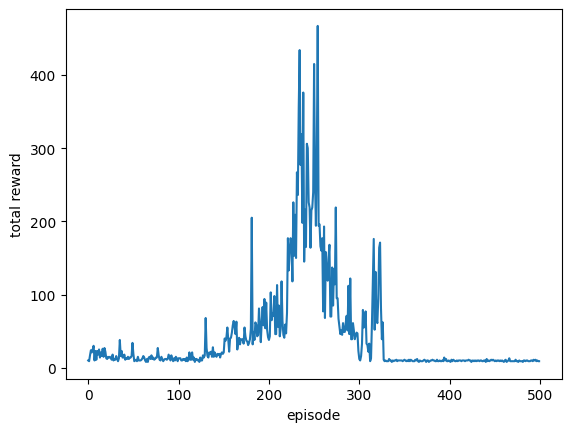

In [49]:


plt.plot(rewards_list)
plt.xlabel('episode')
plt.ylabel('total reward')
plt.show()

## Test the learned policy

In [111]:


env = gym.make("CartPole-v1", render_mode="human")
#env = gym.make("LunarLander-v2", render_mode="human")

state, info = env.reset()
done = False
total_reward = 0

while not done:
    pred = nn_save.forward(unpack_state(state))
    action = np.argmax(pred)  # greedy
    new_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    total_reward += reward
    state = new_state
env.close()

## Exersice 2.5: 

1. What are the similarities between Q-learning and deep Q-learning?

They both use Q-values and aim to maximize cumulative rewards.

2. What are the differences and what implications does these difference have? Are Q-learning and deep Q-learning equally good at the same tasks or are they suited for different problems? 

Q-learning uses a tabular approach. Deep Q-learning uses a neural network approach.
Neural networks can diverge or oscillate during value updates.

3. Are there any difficulties with deep Q-learning?

Balancing the exploration-exploitation trade-off is challenging, and issues like overfitting and other problems can occur.

4. What conclusion can you draw from the the learning curve?

4 The graph initially shows an exponential increase. This suggests that the learning algorithm is quickly gathering knowledge or finding an effective strategy. After reaching a peak the performance declines rapidly which may indicate overfitting or instability as the model starts to over-prioritize certain actions. Finally, the curve converges to a specific y-value, likely reflecting the model settling into a stable policy where it consistently achieves a certain level of reward 

# CNN and pytorch

## Exersice 3.1

Now that we've gained a solid understanding of how neural networks function and how they are trained, we'll shift our focus to tackling an image classification problem. In this instance, we will utilize ready-made packages and libraries to streamline the process.

Debugging neural networks is not an easy task! If you're looking for a helpful resource, the University of Amsterdam's course on debugging neural networks might provide valuable insights and techniques to address common challenges. https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/guide3/Debugging_PyTorch.html

The starting initial code is based on https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

We are going to use the MNIST data set, which containts images of handwritten numbers and your task is to classify the written numbers from the images. 

Your task is to modify the code below to increase the accuracy to atleast 98%. There will hints written throughout below. Then in task 3.2 you will describe the changes you made and try to motivate why you made them.    


In [185]:


import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

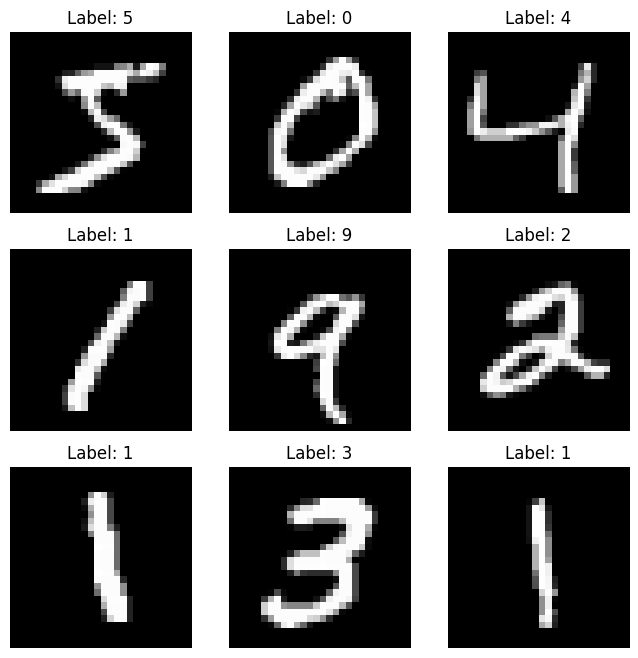

In [186]:


# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# visualize the data
num_images_to_plot = 9
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i in range(num_images_to_plot):
    image, label = training_data[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.show()


In [187]:


# Batch size, this is something you can tune, but the current value is decent.  
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## Define the neural network

Here there is alot of things that can be tuned, I do encurage to add convolutional layers. While it is not neccessary to achive the accuracy, the convolutional layers are very good at images. For example a convolution layer can be defnined as following

self.conv1 = nn.Conv2d(1, 3, 5)

where the first input is the number of in channels. For a grey image there is only one channel, for an rgb image there is 3 channels. The second input is the number of out channels, you can see it as parrallel filters. The last input is the filter size. More infromation exists at https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html. The thing to keep in mind is the dimensions out of convolution. In this case the inpout is 1x28x28 and the output 3x24x24.

In the forward funciton it can be used as

x =  F.relu(self.conv1(x))

And lets say you have defined a linear (dense) layer 

self.fd1 = nn.Linear(3 * 24 * 24, 120)

They can be combined in the forward function as:

x =  F.relu(self.conv1(x))

x = torch.flatten(x, 1) # this flattens the output to a vector

x =  F.relu(self.fd1(x))


A lot of things can be modified here, such as number of layers, the size of the layers, the type of layers. 


In [188]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define the neural network model
class NeuralNetwork_pytorch(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=4) #This layer takes and input image with 1 channel (grayscale) and applies 16 filters (outputs 16 featurs maps) and uses a 4x4 kerner. 
        self.conv2 = nn.Conv2d(16,32, kernel_size=4) #This layer takes the 16 feature maps from the prev lavyer, applies 32 further filters and uses a 4x4 kernel.
        
        self.fd1 = nn.Linear(32*22*22, 512) # Takes the 512 featurs (after flattning the 32 channels of 4x4 features) and maps them to 512 neurons
        self.fd2 = nn.Linear(512, 512) # A second fully connected layer with 512 neurons
        self.fd3 = nn.Linear(512, 10) # Maps the 512 neurons to 10 output neurons, correpsonding to the 10 possible classes (0-9)

    def forward(self, x):
        
        x = (F.relu(self.conv1(x)))  # Input x passes through conv1, then through a ReLu function and then by a pool. 
        x = (F.relu(self.conv2(x)))  # Input x passes through conv2, then through a ReLu function and then by a pool. 
        
        x = torch.flatten(x, 1) #Flattens the 2d feature map into a vector.
        
        #The flattened vector goes through two ReLu-activated layers (fd1 and fd2), then through fd3 which outputs the predictions (logits) for each of the 10 classes
        x = F.relu(self.fd1(x)) 
        x = F.relu(self.fd2(x))
        x = self.fd3(x) # Final layer with no activation (logits)
        
        return x

Using cuda device


In [189]:
# Our traning function, nothing to modify here
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % (100*int(64/batch_size)) == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [191]:
# our test function, nothing to modify here.
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [194]:



# The training loop, here you can change the optimizer, the opimizer is how you update the weights. SGD does 
# gradient decent. Adam optimizer adds some extra steps and regularization. 

epochs = 5 # try to not change the number of epochs, we want something that learns fast. 
           # One epoch trains through all the data. 
    
model = NeuralNetwork_pytorch().to(device)
loss_fn = nn.CrossEntropyLoss() # you can change the loss function 

# you can change the optimizer. The optimizer is how you updates the weights and there are differnet ways to do that.
# For more info see https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html#Optimization
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3) #Weight added for reglurazation

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.307724  [   64/60000]
loss: 0.464238  [ 6464/60000]
loss: 0.359718  [12864/60000]
loss: 0.368388  [19264/60000]
loss: 0.118982  [25664/60000]
loss: 0.258456  [32064/60000]
loss: 0.155885  [38464/60000]
loss: 0.176451  [44864/60000]
loss: 0.165082  [51264/60000]
loss: 0.192400  [57664/60000]
Test Error: 
 Accuracy: 96.2%, Avg loss: 0.118777 

Epoch 2
-------------------------------
loss: 0.062292  [   64/60000]
loss: 0.049327  [ 6464/60000]
loss: 0.166091  [12864/60000]
loss: 0.128372  [19264/60000]
loss: 0.054547  [25664/60000]
loss: 0.044728  [32064/60000]
loss: 0.066340  [38464/60000]
loss: 0.062965  [44864/60000]
loss: 0.119650  [51264/60000]
loss: 0.141898  [57664/60000]
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.066925 

Epoch 3
-------------------------------
loss: 0.016948  [   64/60000]
loss: 0.066714  [ 6464/60000]
loss: 0.081307  [12864/60000]
loss: 0.079567  [19264/60000]
loss: 0.048480  [25664/60000]
loss: 0.016901  [32064/600

## Exersice 3.2: modifications

What modifications did you do and what improvments did you see from them. Can you reason to why they worked?

Text answer: 

Firstly we increased the learning-rate in the SGD model to 1e-1 which saw a nice improvment. From 92percent to 97 percent

Then we started tinkering a bit with the definition of the neural network. We added to two convulutions layers because convulation layers are better for images as they retain spatial information and help the model learn patterns like edges, shapes and textures. This is benifical as seen in the  Origninally we only had fully connected layers for the image data.

We hanged the input size of the first fully connected layder (fd1) to match the ouput form the final convulution layer. This ensured we did not achive any shape mismatch errors.

We also moved the flattening and retained its 2D structure thoughout the convulution layers and flattening afterwards. By not flattening as early our convulutional layers could captue the spacial hierachies in the data, allowing them to detech complex patterns more effectievly.

Using the three modifications above went from a 97 to 98.5 percent accuracy.